# Librerie utilizzate

In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
#python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

import re 

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from gensim import matutils

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
#nltk.download('vader_lexicon')

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

plt.style.use('ggplot')

# Caricamento e pulizia dataset

In [2]:
# Per accedere ai dati dal file CSV, è necessaria una funzione read_csv() che recuperi i dati sotto forma di Dataframe
ScholarsEn = pd.read_csv(r"C:\Users\matte\Downloads\TMIN\ScholarsEn.csv")

In [3]:
# Utilizzo della funzione .head() per visualizzare le prime 5 righe del DataFrame ScholarsEn
ScholarsEn.head()

,Username,Review Number,Title,Text,Date,Rating,Rating.1,Rating.2,Rating.3,Rating.4
0,Mon-coach i,37 reviews,We had so much fun,"""We had so much fun. It was my first time goin...",Date of visit: June 2022,5.0,NaN,NaN,NaN,NaN
1,GoldstarDancer,31 reviews,Shocking Overcrowding,On our trip to Rome we spent about 1/2 hrs in ...,Date of visit: March 2023,NaN,NaN,NaN,2.0,NaN
2,theokietravelbird,47 reviews,Best Pub!,We went there for St. Patrick's Day and had a ...,Date of visit: March 2023,5.0,NaN,NaN,NaN,NaN
3,AndreaE2327,1 review,Very rude security staff,"They let enter first just the girls they like,...",Date of visit: March 2023,NaN,NaN,NaN,NaN,1.0
4,R7169YHdarrenm,1 review,Overpriced and terrible food,For the price they charge the food is terrible...,Date of visit: March 2023,NaN,NaN,NaN,NaN,1.0


In [4]:
# Creazione di una nuova colonna chiamata 'combined_rating' che combina i valori delle colonne 'Rating', 'Rating.1', 'Rating.2', 'Rating.3', 'Rating.4', sostituendo i valori mancanti con il metodo 'ffill' (forward fill) e selezionando l'ultimo valore della riga
ScholarsEn['combined_rating'] = ScholarsEn[['Rating', 'Rating.1', 'Rating.2', 'Rating.3', 'Rating.4']].fillna(method='ffill', axis=1).iloc[:, -1]

# Rimozione delle colonne 'Rating', 'Rating.1', 'Rating.2', 'Rating.3', 'Rating.4' dal DataFrame ScholarsEn
ScholarsEn = ScholarsEn.drop(columns=['Rating', 'Rating.1', 'Rating.2', 'Rating.3', 'Rating.4'])

# Rinomina delle colonne 'ï..Username' e 'combined_rating' in 'Username' e 'Rating', rispettivamente
ScholarsEn = ScholarsEn.rename(columns={'ï..Username': 'Username', 'combined_rating': 'Rating'})

# Rimozione del prefisso "Date of visit: " dalla colonna 'Date' nel DataFrame ScholarsEn
ScholarsEn['Date'] = ScholarsEn['Date'].str.replace("Date of visit: ", "")

# Rimozione delle stringhe " reviews" e " review" dalla colonna 'Review Number' nel DataFrame ScholarsEn
ScholarsEn['Review Number'] = ScholarsEn['Review Number'].str.replace(" reviews", "").str.replace(" review", "")

# Creazione di un nuovo DataFrame 'df' con gli stessi dati di ScholarsEn
df = ScholarsEn

# Estrazione degli ultimi 4 caratteri dalla colonna 'Date' nel DataFrame df
df['Date'] = df['Date'].str[-4:]

# Aggiunta di una colonna 'Id' che contiene un numero incrementale da 1 alla lunghezza del DataFrame df
df['Id'] = range(1, len(df) + 1)

# Conversione delle colonne 'Text' e 'Title' in tipo stringa nel DataFrame df
df['Text'] = df['Text'].astype(str)
df['Title'] = df['Title'].astype(str)

# Stampa dei tipi di dati delle colonne nel DataFrame df
print(df.dtypes)

Username          object
Review Number     object
Title             object
Text              object
Date              object
Rating           float64
Id                 int64
dtype: object


In [5]:
# Visualizzazione delle informazioni sul DataFrame df, inclusi il numero di righe, il numero di colonne e il tipo di dati di ciascuna colonna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Username       1725 non-null   object 
 1   Review Number  1723 non-null   object 
 2   Title          1725 non-null   object 
 3   Text           1725 non-null   object 
 4   Date           1634 non-null   object 
 5   Rating         1725 non-null   float64
 6   Id             1725 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 94.5+ KB


In [6]:
# Calcolo del numero di valori nulli per ciascuna colonna nel DataFrame df
df.isnull().sum()

Username          0
Review Number     2
Title             0
Text              0
Date             91
Rating            0
Id                0
dtype: int64

In [7]:
# Creazione di una nuova colonna chiamata "review" nel DataFrame df che combina le colonne "Title" e "Text", separandole con uno spazio
df["review"] = df["Title"].map(str) + " " + df["Text"]

In [8]:
# Applicazione di una funzione lambda a ogni valore nella colonna 'review' per rimuovere tutti i caratteri non alfabetici e non spazi, sostituendoli con una stringa vuota
df['review'] = df['review'].apply(lambda x: re.sub(r'[^A-Za-z\s]', '', x))

# Trasformazione di tutti i valori nella colonna 'review' in minuscolo utilizzando una funzione lambda
df['review'] = df['review'].map(lambda x: x.lower())

# Visualizzazione della colonna 'review' del DataFrame df
df.review

0       we had so much fun we had so much fun it was m...
1       shocking overcrowding on our trip to rome we s...
2       best pub we went there for st patricks day and...
3       very rude security staff they let enter first ...
4       overpriced and terrible food for the price the...
                              ...                        
1720    loved the scholars lounge the scholars lounge ...
1721    lovely food really would recomend this bar fri...
1722    good craic i went to scholars lounge in rome w...
1723    expensive drinks popped in on a sat evening go...
1724    awful service awful attitude horrible disapoin...
Name: review, Length: 1725, dtype: object

In [9]:
# Utilizzo della funzione .head() per visualizzare le prime 5 righe del nuovo DataFrame
df.head()

,Username,Review Number,Title,Text,Date,Rating,Id,review
0,Mon-coach i,37,We had so much fun,"""We had so much fun. It was my first time goin...",2022,5.0,1,we had so much fun we had so much fun it was m...
1,GoldstarDancer,31,Shocking Overcrowding,On our trip to Rome we spent about 1/2 hrs in ...,2023,2.0,2,shocking overcrowding on our trip to rome we s...
2,theokietravelbird,47,Best Pub!,We went there for St. Patrick's Day and had a ...,2023,5.0,3,best pub we went there for st patricks day and...
3,AndreaE2327,1,Very rude security staff,"They let enter first just the girls they like,...",2023,1.0,4,very rude security staff they let enter first ...
4,R7169YHdarrenm,1,Overpriced and terrible food,For the price they charge the food is terrible...,2023,1.0,5,overpriced and terrible food for the price the...


In [10]:
# Creazione di un nuovo DataFrame chiamato IRDR con le colonne 'Id', 'Rating', 'Date' e 'Review' utilizzando i valori corrispondenti dal DataFrame df
IRDR = pd.DataFrame({
    'Id': df['Id'],
    'Rating': df['Rating'],
    'Date': df['Date'],
    'Review': df['review']
})

# Download delle stopwords (parole comuni da ignorare) utilizzate successivamente per la rimozione delle parole di arresto nel testo delle recensioni
# nltk.download('stopwords')

# Download del tokenizer per la suddivisione del testo in token (parole o frasi) utilizzate successivamente per la suddivisione delle recensioni in parole
# nltk.download('punkt')

# Creazione di un set di stopwords in lingua inglese
stop_words = set(stopwords.words('english'))

# Applicazione di una funzione lambda alla colonna 'Review' del DataFrame IRDR per suddividerla in parole utilizzando il tokenizer
IRDR['word'] = IRDR['Review'].apply(lambda x: word_tokenize(x))

# Esplosione del DataFrame IRDR sulla colonna 'word' per ottenere un nuovo DataFrame in cui ogni parola è in una riga separata
IRDR = IRDR.explode('word')

# Filtraggio delle righe del DataFrame IRDR in cui la colonna 'word' corrisponde a una sequenza di caratteri alfabetici minuscoli o apostrofi e non è presente nelle stopwords
IRDR = IRDR[IRDR['word'].str.match('[a-z\']+$') & ~IRDR['word'].isin(stop_words)]

In [11]:
IRDR.head()

,Id,Rating,Date,Review,word
0,1,5.0,2022,we had so much fun we had so much fun it was m...,much
0,1,5.0,2022,we had so much fun we had so much fun it was m...,fun
0,1,5.0,2022,we had so much fun we had so much fun it was m...,much
0,1,5.0,2022,we had so much fun we had so much fun it was m...,fun
0,1,5.0,2022,we had so much fun we had so much fun it was m...,first


## Tokenizzazione

In [12]:
# Assegnazione del valore della colonna 'review' della decima riga del DataFrame df alla variabile 'example'
example = df['review'][10]

# Stampa del valore contenuto nella variabile 'example'
print(example)

disappointed the place has a wonderful irish pub feel and can imagine when it is full there would be some atmosphere  we popped in for a drink and food at the end of a long day of sightseeing
we had a pint of lager  anda double gin and tonic  the pint price is the going rate for rome but the gin was a little overpriced 
gin was what you would expect the lager on the other hand was fowl  it tasted and smelt like sweaty feet 
we decided not to try the food and left with the lager undrunkmore


In [13]:
# Tokenizzazione del testo contenuto nella variabile 'example' utilizzando il tokenizer di nltk
tokens = nltk.word_tokenize(example)

# Estrazione dei primi 10 token dalla lista di token
tokens[:10]

['disappointed',
 'the',
 'place',
 'has',
 'a',
 'wonderful',
 'irish',
 'pub',
 'feel',
 'and']

In [14]:
# Download del modello POS tagger 'averaged_perceptron_tagger' utilizzato per etichettare le parti del discorso
# nltk.download('averaged_perceptron_tagger')

# Applicazione del POS tagger ai token utilizzando il modello 'averaged_perceptron_tagger'
tagged = nltk.pos_tag(tokens)

# Estrazione delle prime 10 coppie (token, etichetta POS) dalla lista di token etichettati
tagged[:10]

[('disappointed', 'VBN'),
 ('the', 'DT'),
 ('place', 'NN'),
 ('has', 'VBZ'),
 ('a', 'DT'),
 ('wonderful', 'JJ'),
 ('irish', 'JJ'),
 ('pub', 'NN'),
 ('feel', 'NN'),
 ('and', 'CC')]

In [15]:
# Download del modello 'maxent_ne_chunker' utilizzato per l'estrazione di entità
# nltk.download('maxent_ne_chunker')

# Download del corpus 'words' utilizzato per l'estrazione di entità
# nltk.download('words')

# Applicazione del chunker per l'estrazione di entità ai token etichettati
entities = nltk.chunk.ne_chunk(tagged)

# Stampa formattata delle entità estratte
entities.pprint()

(S
  disappointed/VBN
  the/DT
  place/NN
  has/VBZ
  a/DT
  wonderful/JJ
  irish/JJ
  pub/NN
  feel/NN
  and/CC
  can/MD
  imagine/VB
  when/WRB
  it/PRP
  is/VBZ
  full/JJ
  there/EX
  would/MD
  be/VB
  some/DT
  atmosphere/NN
  we/PRP
  popped/VBD
  in/IN
  for/IN
  a/DT
  drink/NN
  and/CC
  food/NN
  at/IN
  the/DT
  end/NN
  of/IN
  a/DT
  long/JJ
  day/NN
  of/IN
  sightseeing/VBG
  we/PRP
  had/VBD
  a/DT
  pint/NN
  of/IN
  lager/NN
  anda/NN
  double/JJ
  gin/NN
  and/CC
  tonic/VB
  the/DT
  pint/NN
  price/NN
  is/VBZ
  the/DT
  going/VBG
  rate/NN
  for/IN
  rome/NN
  but/CC
  the/DT
  gin/NN
  was/VBD
  a/DT
  little/JJ
  overpriced/JJ
  gin/NN
  was/VBD
  what/WP
  you/PRP
  would/MD
  expect/VB
  the/DT
  lager/NN
  on/IN
  the/DT
  other/JJ
  hand/NN
  was/VBD
  fowl/NN
  it/PRP
  tasted/VBD
  and/CC
  smelt/VBD
  like/IN
  sweaty/JJ
  feet/NNS
  we/PRP
  decided/VBD
  not/RB
  to/TO
  try/VB
  the/DT
  food/NN
  and/CC
  left/VBD
  with/IN
  the/DT
  lager/NN
  undru

## Stopwords

In [16]:
# Creazione di una lista di stopwords in lingua inglese utilizzando il modulo 'stopwords' di nltk
stop_words = stopwords.words("english")

In [17]:
# Definizione di una funzione chiamata 'lematized_review' che prende in input un testo
def lematized_review(text):
    # Elaborazione del testo utilizzando il modulo 'nlp' di spacy
    rev_text = nlp(text)
    # Creazione di una lista di lemmi convertiti in minuscolo per ciascun token nel testo,
    # ignorando i token che sono stopwords, che si trovano nell'elenco di stopwords e che non sono punteggiatura,
    # e che hanno una lunghezza maggiore di 3 caratteri
    rev_text = ([token.lemma_.lower() for token in rev_text if not token.is_stop and token.text not in stop_words and not token.is_punct and len(token.text) > 3])
    # Restituzione della lista di lemmi elaborati
    return rev_text

In [18]:
# Misurazione del tempo di esecuzione del blocco di codice seguente
#%%time

# Applicazione della funzione 'lematized_review' a ogni valore nella colonna 'review' del DataFrame df
df["review_stop"] = df["review"].apply(lematized_review)

In [19]:
# Assegnazione della colonna 'review_stop' del DataFrame df alla variabile 'clean_df_review'
clean_df_review = df["review_stop"]

In [20]:
# Restituzione della variabile 'clean_df_review'
clean_df_review

0       [time, go, club, drink, perfect, music, karaok...
1       [shock, overcrowding, trip, rome, spend, schol...
2       [good, go, patrick, wonderful, time, music, am...
3       [rude, security, staff, enter, girl, like, fri...
4       [overpriced, terrible, food, price, charge, fo...
                              ...                        
1720    [love, scholar, lounge, scholar, lounge, beaut...
1721    [lovely, food, recomend, friendly, irish, staf...
1722    [good, craic, go, scholar, lounge, rome, colle...
1723    [expensive, drink, pop, evening, good, crowd, ...
1724    [awful, service, awful, attitude, horrible, di...
Name: review_stop, Length: 1725, dtype: object

# Analisi preliminari

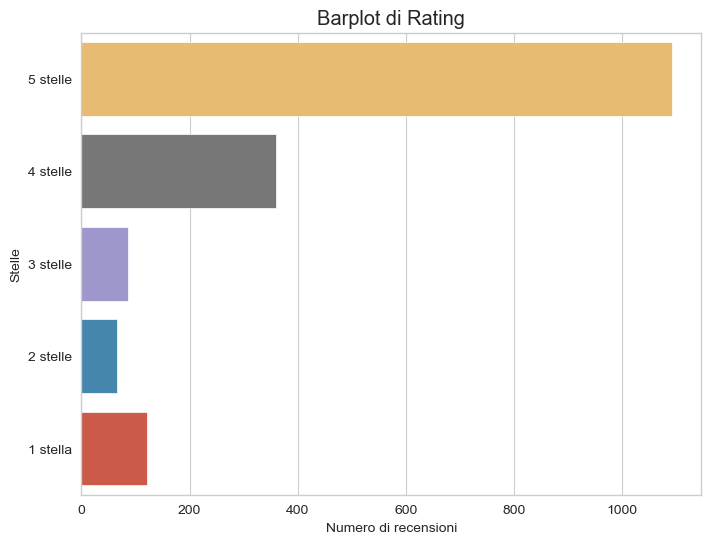

In [24]:
# Assegnazione di una nuova colonna 'rating_group' al DataFrame df basata sulla colonna 'Rating' con intervalli predefiniti e relative etichette
df['Rating'] = pd.cut(df['Rating'], bins=[0,1,2,3,4,5], labels=['1 stella', '2 stelle', '3 stelle', '4 stelle', '5 stelle'])

# Creazione di una figura con dimensioni (larghezza, altezza) specificate
plt.figure(figsize=(8, 6))

# Impostazione dello stile dello sfondo del grafico a griglia bianca
sns.set_style("whitegrid")

# Creazione di un countplot orizzontale con l'asse y corrispondente alla colonna 'rating_group' del DataFrame df
sns.countplot(y='Rating', data=df)

# Etichettatura dell'asse x con "Numero di recensioni"
plt.xlabel("Numero di recensioni")

# Etichettatura dell'asse y con "Stelle"
plt.ylabel("Stelle")

# Impostazione del titolo del grafico come "Barplot of Rating"
plt.title("Barplot di Rating")

# Inversione dell'asse y per visualizzare le etichette delle stelle in ordine decrescente
plt.gca().invert_yaxis()

#plt.savefig('rating.png')

# Visualizzazione del grafico
plt.show()

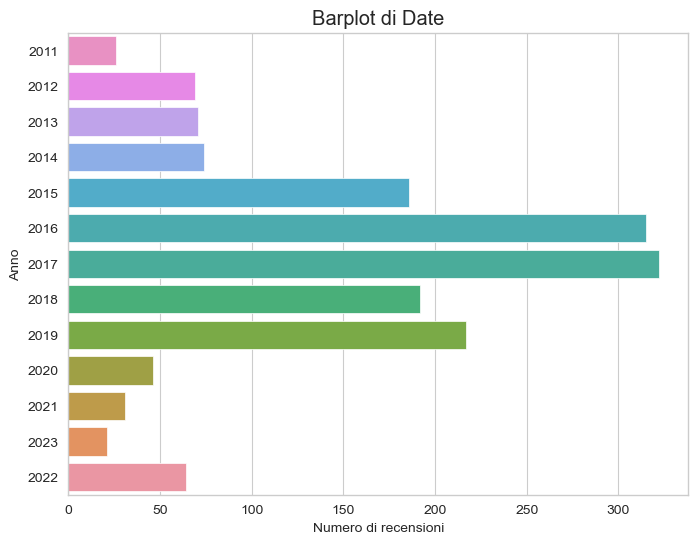

In [28]:
# Creazione di una figura con dimensioni (larghezza, altezza) specificate
plt.figure(figsize=(8, 6))

# Impostazione dello stile dello sfondo del grafico a griglia bianca
sns.set_style("whitegrid")

# Creazione di un countplot orizzontale con l'asse y corrispondente alla colonna 'Date' del DataFrame df
sns.countplot(y='Date', data=df)

# Etichettatura dell'asse x con "Numero di recensioni"
plt.xlabel("Numero di recensioni")

# Etichettatura dell'asse y con "Anno"
plt.ylabel("Anno")

# Impostazione del titolo del grafico come "Barplot of Date"
plt.title("Barplot di Date")

# Inversione dell'asse y per visualizzare le etichette degli anni in ordine decrescente
plt.gca().invert_yaxis()

#plt.savefig('date.png')

# Visualizzazione del grafico
plt.show()

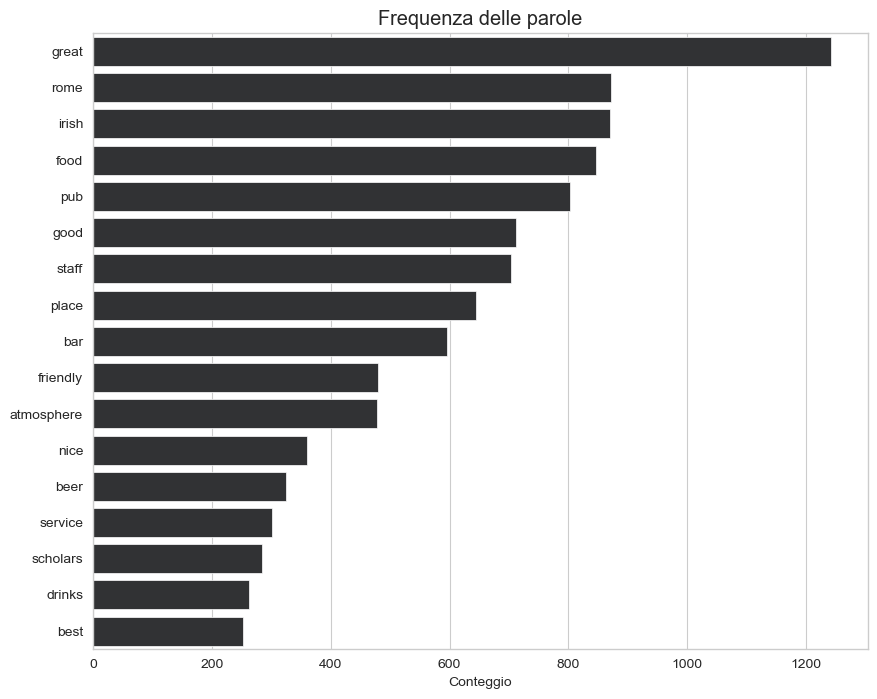

In [40]:
# Impostazione dello stile dello sfondo del grafico a griglia bianca
sns.set_style("whitegrid")

# Calcolo della frequenza delle parole nella colonna 'word' del DataFrame 'IRDR' e creazione di un nuovo DataFrame 'freq'
freq = IRDR['word'].value_counts().reset_index()

# Rinominazione delle colonne del DataFrame 'freq' come 'word' e 'n'
freq.columns = ['word', 'n']

# Ordinamento del DataFrame 'freq' in base alla colonna 'n' in ordine decrescente
freq = freq.sort_values('n', ascending=False)

# Filtraggio delle parole con frequenza superiore a 250
filtered_freq = freq[freq['n'] > 250].sort_values('n')

# Creazione del grafico a barre orizzontali utilizzando seaborn
plt.figure(figsize=(10, 8))
sns.barplot(data=filtered_freq, y='word', x='n', color='#303234')

# Etichettatura dell'asse x con 'Count'
plt.xlabel('Conteggio')

# Rimozione dell'etichetta dell'asse y nel grafico
plt.ylabel('')

# Impostazione del titolo del grafico come 'Word Frequency'
plt.title('Frequenza delle parole')

# Inversione dell'asse y per visualizzare le etichette degli anni in ordine decrescente
plt.gca().invert_yaxis()

#plt.savefig('frequency.png')

# Visualizzazione del grafico
plt.show()

In [161]:
# Raggruppamento del DataFrame IRDR per 'Date' e 'word', conteggio delle occorrenze e ordinamento in base a 'Date' e 'count'
words_by_year = IRDR.groupby(['Date', 'word']).size().reset_index(name='count').sort_values(['Date', 'count'], ascending=False).reset_index(drop=True)

# Restituzione della variabile 'words_by_year'
words_by_year

,Date,word,count
0,2023,food,19
1,2023,staff,15
2,2023,bar,14
3,2023,place,12
4,2023,rome,12
...,...,...,...
12771,2011,win,1
12772,2011,wings,1
12773,2011,wingsmore,1
12774,2011,withmore,1


In [160]:
# Raggruppamento del DataFrame IRDR per 'Rating' e 'word', conteggio delle occorrenze e ordinamento in base a 'Rating' e 'count'
words_by_stars = IRDR.groupby(['Rating', 'word']).size().reset_index(name='count').sort_values(['Rating', 'count'], ascending=False).reset_index(drop=True)

# Restituzione della variabile 'words_by_stars'
words_by_stars

,Rating,word,count
0,5,great,968
1,5,rome,639
2,5,irish,571
3,5,food,558
4,5,pub,540
...,...,...,...
8481,1,year,1
8482,1,years,1
8483,1,yes,1
8484,1,yet,1


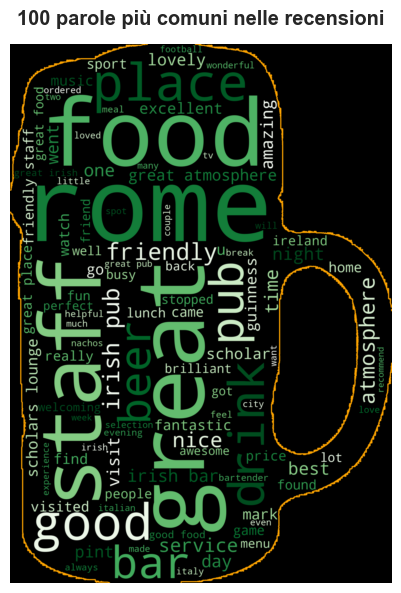

In [49]:
# Unione delle recensioni in una lunga stringa separata da virgole
long_string = ','.join(list(df.review.values))

# Caricamento di un'immagine come maschera per il WordCloud
beer_mask = np.array(Image.open("C:/Users/matte/Downloads/beer_cloud.png"))

# Creazione di un oggetto WordCloud con specifiche opzioni
wordcloud = WordCloud(background_color="black", mask=beer_mask, colormap="Greens", max_words=100, contour_width=5, contour_color='orange')

# Generazione del WordCloud basato sulla lunga stringa di recensioni
wordcloud.generate(long_string)

# Creazione di una figura con dimensioni specificate
plt.figure(figsize=(20, 7))

# Visualizzazione del WordCloud
plt.imshow(wordcloud, interpolation='bilinear')

# Rimozione degli assi nel grafico
plt.axis('off')

# Impostazione del titolo del grafico
plt.title("100 parole più comuni nelle recensioni", pad=14, weight='bold')

# Mostrare il grafico
plt.show()

In [50]:
#wordcloud.to_file("irishcloud.png")

# Sentiment Analysis

## Vader

In [21]:
# Creazione di un oggetto SentimentIntensityAnalyzer dalla libreria NLTK
sia = SentimentIntensityAnalyzer()

In [22]:
# Calcolo del sentiment polarity score per la frase 'I am so happy!'
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [23]:
# Calcolo del sentiment polarity score per la frase 'This is the worst thing ever'
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [24]:
# La variabile 'example' contiene un esempio di review
example

'disappointed the place has a wonderful irish pub feel and can imagine when it is full there would be some atmosphere  we popped in for a drink and food at the end of a long day of sightseeing\nwe had a pint of lager  anda double gin and tonic  the pint price is the going rate for rome but the gin was a little overpriced \ngin was what you would expect the lager on the other hand was fowl  it tasted and smelt like sweaty feet \nwe decided not to try the food and left with the lager undrunkmore'

In [25]:
# Calcolo del sentiment polarity score per il testo 'example'
sia.polarity_scores(example)

{'neg': 0.02, 'neu': 0.883, 'pos': 0.097, 'compound': 0.8338}

In [56]:
# Creazione di un dizionario vuoto per memorizzare i risultati delle analisi di sentiment
res = {}

# Iterazione attraverso ogni riga del DataFrame df utilizzando tqdm per visualizzare una barra di avanzamento
# e ottenere l'indice della riga (i) e i valori della riga (row)
for i, row in tqdm(df.iterrows(), total=len(df)):
    # Ottenimento del testo della recensione dalla colonna 'review'
    text = row['review']
    # Ottenimento dell'ID dalla colonna 'Id'
    myid = row['Id']
    # Calcolo del sentiment polarity score per il testo della recensione utilizzando l'oggetto sia
    # e memorizzazione del risultato nel dizionario res con l'ID come chiave
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1725 [00:00<?, ?it/s]

In [57]:
# Creazione di un DataFrame 'vaders' dai risultati dell'analisi di sentiment, trasponendoli e impostando l'ID come indice
vaders = pd.DataFrame(res).T

# Reset dell'indice del DataFrame 'vaders' e rinominazione della colonna 'index' in 'Id'
vaders = vaders.reset_index().rename(columns={'index': 'Id'})

# Unione del DataFrame 'vaders' con il DataFrame 'df' utilizzando una fusione sinistra (left join)
vaders = vaders.merge(df, how='left')

In [58]:
# Utilizzo della funzione .head() per visualizzare le prime 5 righe del nuovo DataFrame vaders
vaders.head()

,Id,neg,neu,pos,compound,Username,Review Number,Title,Text,Date,Rating,review,rating_group
0,1,0.000,0.660,0.340,0.9428,Mon-coach i,37,We had so much fun,"""We had so much fun. It was my first time goin...",2022,5 stelle,we had so much fun we had so much fun it was m...,5 stars
1,2,0.094,0.840,0.067,-0.3197,GoldstarDancer,31,Shocking Overcrowding,On our trip to Rome we spent about 1/2 hrs in ...,2023,2 stelle,shocking overcrowding on our trip to rome we s...,2 stars
2,3,0.000,0.589,0.411,0.9810,theokietravelbird,47,Best Pub!,We went there for St. Patrick's Day and had a ...,2023,5 stelle,best pub we went there for st patricks day and...,5 stars
3,4,0.138,0.782,0.080,-0.8317,AndreaE2327,1,Very rude security staff,"They let enter first just the girls they like,...",2023,1 stella,very rude security staff they let enter first ...,1 star
4,5,0.139,0.763,0.098,-0.2505,R7169YHdarrenm,1,Overpriced and terrible food,For the price they charge the food is terrible...,2023,1 stella,overpriced and terrible food for the price the...,1 star


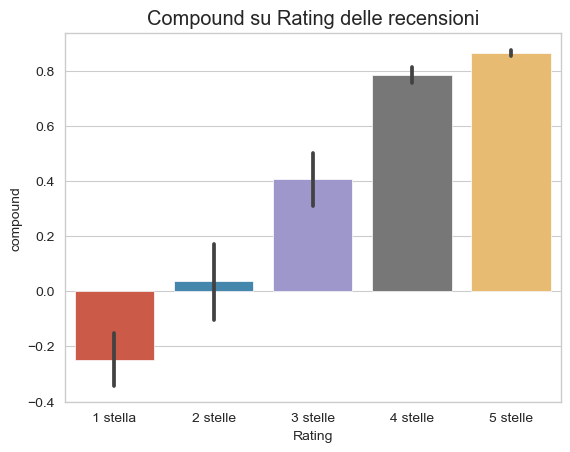

In [62]:
# Creazione di un barplot utilizzando il DataFrame 'vaders', con 'Rating' come asse x e 'compound' come asse y
ax = sns.barplot(data=vaders, x='Rating', y='compound')

# Impostazione del titolo del grafico
ax.set_title('Compound su Rating delle recensioni')

#plt.savefig('compound.png')

# Visualizzazione del grafico
plt.show()

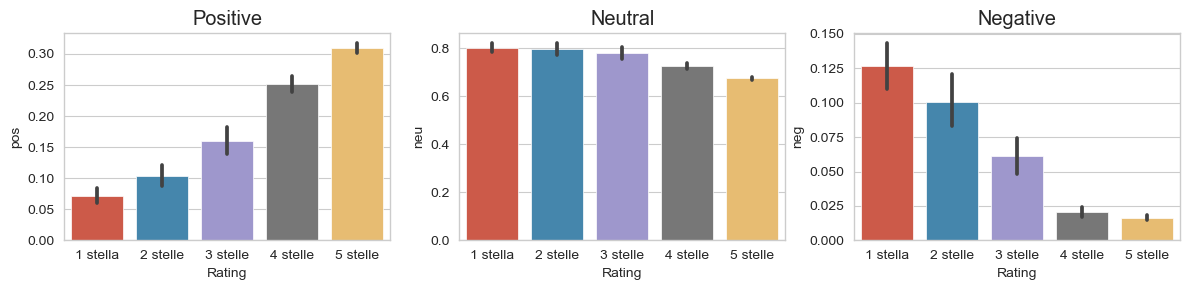

In [63]:
# Creazione di una figura con 3 subplot, dimensioni (12, 3)
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Barplot per la colonna 'pos' in base al 'Rating', con il primo subplot axs[0]
sns.barplot(data=vaders, x='Rating', y='pos', ax=axs[0])

# Barplot per la colonna 'neu' in base al 'Rating', con il secondo subplot axs[1]
sns.barplot(data=vaders, x='Rating', y='neu', ax=axs[1])

# Barplot per la colonna 'neg' in base al 'Rating', con il terzo subplot axs[2]
sns.barplot(data=vaders, x='Rating', y='neg', ax=axs[2])

# Impostazione del titolo per il primo subplot
axs[0].set_title('Positive')

# Impostazione del titolo per il secondo subplot
axs[1].set_title('Neutral')

# Impostazione del titolo per il terzo subplot
axs[2].set_title('Negative')

# Aggiustamento dello spaziamento tra i subplot
plt.tight_layout()

#plt.savefig('posneuneg.png')

# Visualizzazione della figura
plt.show()

## Roberta

In [35]:
# Definizione del modello pre-addestrato utilizzato, in questo caso "cardiffnlp/twitter-roberta-base-sentiment"
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

# Creazione del tokenizer utilizzando il modello pre-addestrato
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Creazione del modello per la classificazione di sequenze utilizzando il modello pre-addestrato
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [36]:
# VADER

# Stampa del valore della variabile 'example'
print(example)

# Calcolo del punteggio di sentiment analizzando la variabile 'example' con SentimentIntensityAnalyzer
sia.polarity_scores(example)

disappointed the place has a wonderful irish pub feel and can imagine when it is full there would be some atmosphere  we popped in for a drink and food at the end of a long day of sightseeing
we had a pint of lager  anda double gin and tonic  the pint price is the going rate for rome but the gin was a little overpriced 
gin was what you would expect the lager on the other hand was fowl  it tasted and smelt like sweaty feet 
we decided not to try the food and left with the lager undrunkmore


{'neg': 0.02, 'neu': 0.883, 'pos': 0.097, 'compound': 0.8338}

In [37]:
# Codifica del testo utilizzando il tokenizer, restituendo i tensori di input per il modello
encoded_text = tokenizer(example, return_tensors='pt')

# Passaggio del testo codificato al modello per ottenere l'output
output = model(**encoded_text)

# Estrazione dei punteggi di sentiment dall'output del modello e conversione in un array NumPy
scores = output[0][0].detach().numpy()

# Applicazione della funzione softmax ai punteggi per ottenere probabilità normalizzate
scores = softmax(scores)

# Creazione di un dizionario che associa i punteggi a etichette specifiche
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2],
}

# Stampa del dizionario contenente i punteggi di sentiment
print(scores_dict)

{'roberta_neg': 0.40062717, 'roberta_neu': 0.3998137, 'roberta_pos': 0.19955912}


In [38]:
# Definizione di una funzione per calcolare i punteggi di sentiment utilizzando il modello RoBERTa
def polarity_scores_roberta(example):
    # Codifica del testo utilizzando il tokenizer, restituendo i tensori di input per il modello
    encoded_text = tokenizer(example, return_tensors='pt')
    # Passaggio del testo codificato al modello per ottenere l'output
    output = model(**encoded_text)
    # Estrazione dei punteggi di sentiment dall'output del modello e conversione in un array NumPy
    scores = output[0][0].detach().numpy()
    # Applicazione della funzione softmax ai punteggi per ottenere probabilità normalizzate
    scores = softmax(scores)
    # Creazione di un dizionario che associa i punteggi a etichette specifiche
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2],
    }
    # Restituzione del dizionario dei punteggi di sentiment
    return scores_dict

In [39]:
# Creazione di un dizionario per memorizzare i risultati
res = {}

# Iterazione sul DataFrame utilizzando tqdm per mostrare una barra di avanzamento
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        # Estrazione del testo e dell'ID della recensione
        text = row['review']
        myid = row['Id']
        # Calcolo dei punteggi di sentiment con il modello VADER
        vader_result = sia.polarity_scores(text)
        # Rinominazione delle chiavi del dizionario di risultato VADER
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        # Calcolo dei punteggi di sentiment con il modello RoBERTa
        roberta_result = polarity_scores_roberta(text)
        # Combinazione dei risultati dei due modelli in un unico dizionario
        both = {**vader_result_rename, **roberta_result}
        # Aggiunta del dizionario di risultato all'ID corrispondente nel dizionario principale
        res[myid] = both
    except RuntimeError:
        # Gestione delle eccezioni in caso di errori durante l'elaborazione di una recensione
        print(f"Broke for id {myid}")

  0%|          | 0/1725 [00:00<?, ?it/s]

In [40]:
# Creazione di un DataFrame dai risultati
results_df = pd.DataFrame(res).T

# Ripristino dell'indice e rinominazione della colonna 'index' in 'Id'
results_df = results_df.reset_index().rename(columns={'index': 'Id'})

# Unione del DataFrame dei risultati con il DataFrame originale 'df' utilizzando l'ID come chiave di unione
results_df = results_df.merge(df, how='left')

## Compare Scores 

In [42]:
# Stampare le colonne del DataFrame results_df
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Username',
       'Review Number', 'Title', 'Text', 'Date', 'Rating', 'review',
       'review_stop', 'rating_group'],
      dtype='object')

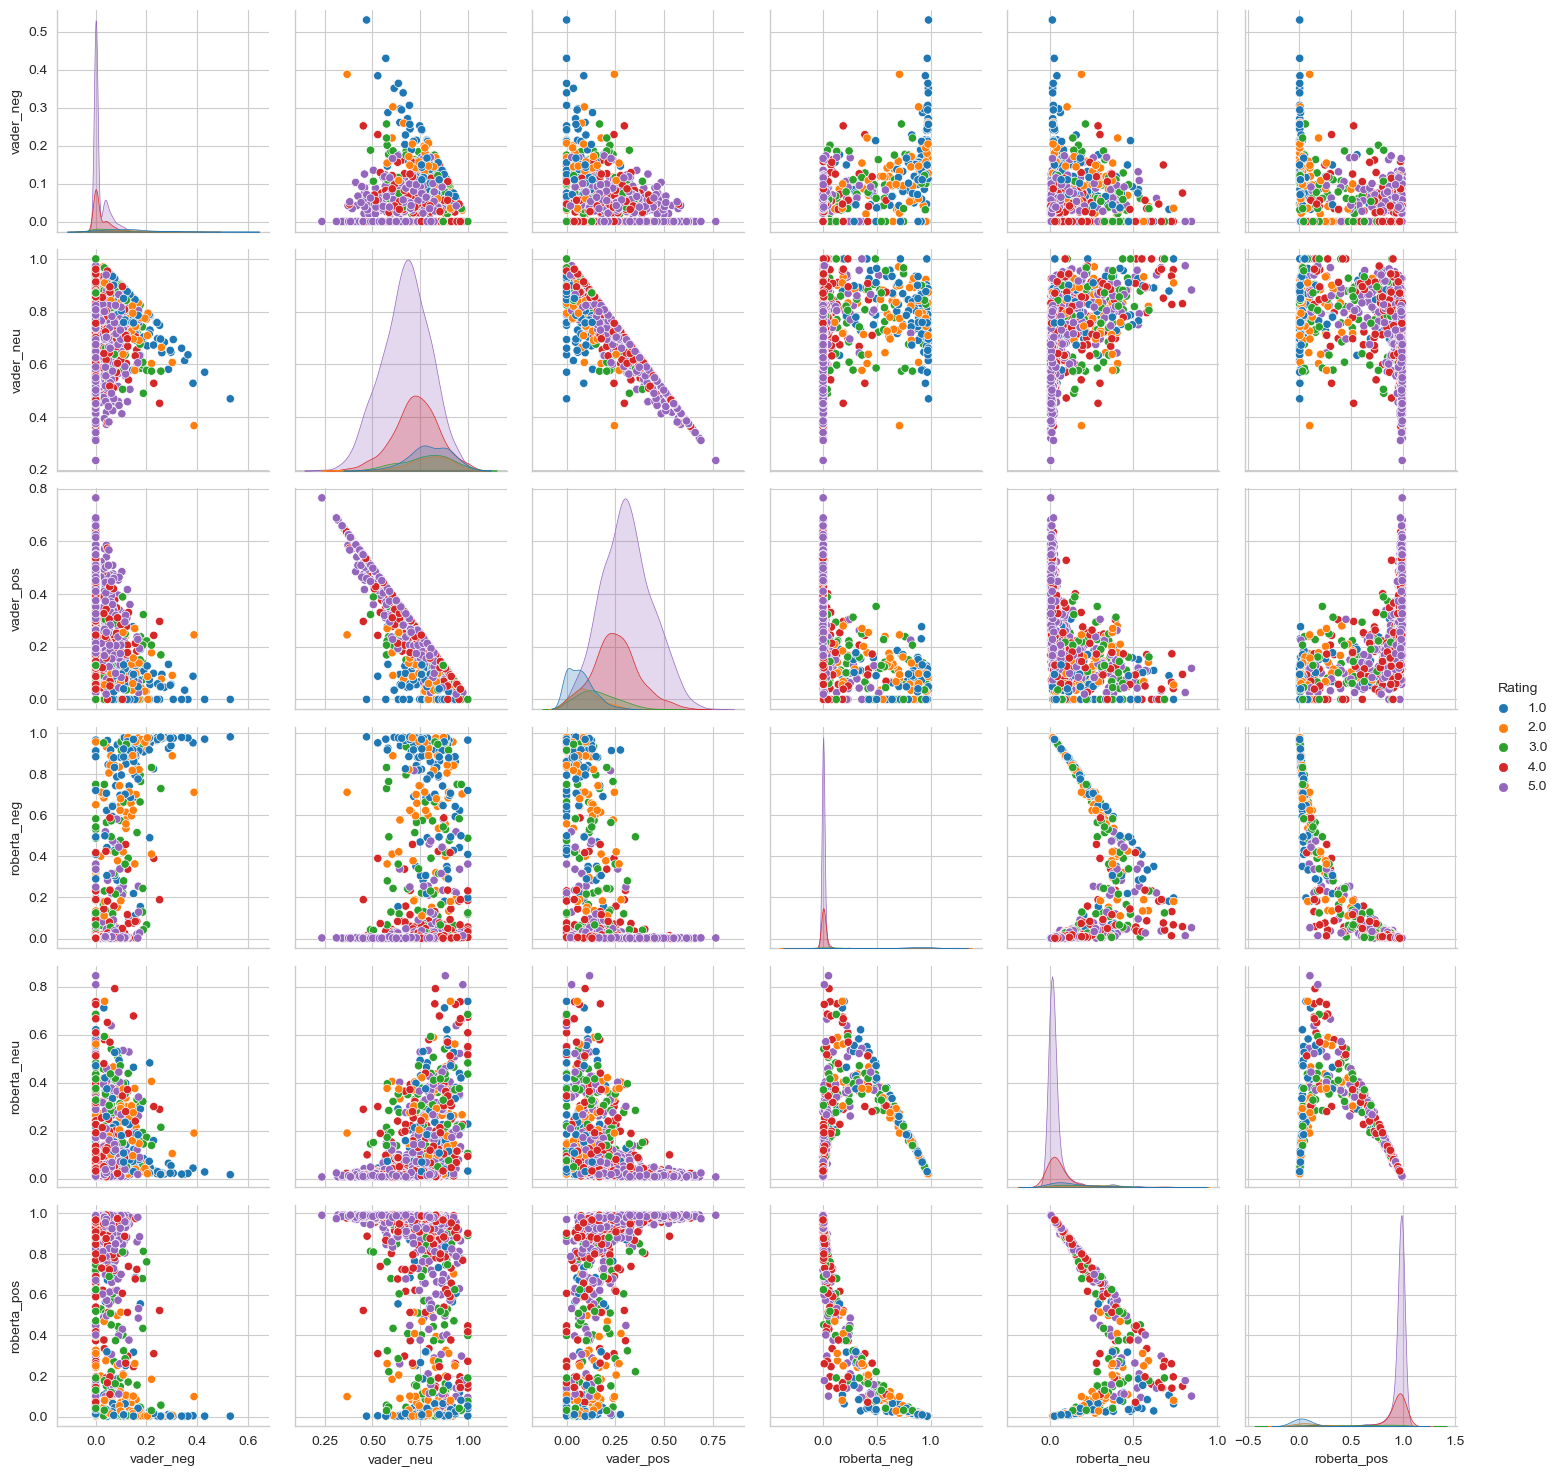

In [155]:
# Creare un grafico a coppie utilizzando le variabili specificate e colorando i punti in base alla colonna 'Rating'
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Rating',
             palette='tab10')

#plt.savefig('pairplot.png')

# Visualizzare il grafico a coppie
plt.show()

In [48]:
# Selezionare la recensione con la valutazione 'Rating' pari a 1, ordinata per il punteggio 'roberta_pos' in ordine decrescente e selezionare il valore nella colonna 'review'
results_df.query('Rating == 1').sort_values('roberta_pos', ascending = False)['review'].values[0]

'birthday party it was one of my favourite places to come before i did my birthday party there \ni loved the place before because it is the only pub where i feel the international atmosphere and that is why i decided to make my birthday party theremore'

In [49]:
# Selezionare la recensione con la valutazione 'Rating' pari a 1, ordinata per il punteggio 'vader_pos' in ordine decrescente e selezionare il valore nella colonna 'review'
results_df.query('Rating == 1').sort_values('vader_pos', ascending = False)['review'].values[0]

'should be called linekers sports bar in italian we have been here two evenings running  both evenings started well with the friendly familiarity of a great irish bar oak brass whiskey guinness and typical best friend irish waiter there are numerous tvs throughout the bar showing champions league and europa league football allmore'

In [50]:
# Selezionare la recensione con la valutazione 'Rating' pari a 5, ordinata per il punteggio 'roberta_neg' in ordine decrescente e selezionare il valore nella colonna 'review'
results_df.query('Rating == 5').sort_values('roberta_neg', ascending = False)['review'].values[0]

'a door to ireland in the middle of rome i entered this pub with prejudices because theres millions of place like this all over italy but its hard they catch the true irish spirit well i couldnt be more wrong\nbasically all the personal comes from ireland or at least have relatives you canmore'

In [51]:
# Selezionare la recensione con la valutazione 'Rating' pari a 5, ordinata per il punteggio 'vader_neg' in ordine decrescente e selezionare il valore nella colonna 'review'
results_df.query('Rating == 5').sort_values('vader_neg', ascending = False)['review'].values[0]

'an oasis in rome we loved the scholars  we were suffering from crowd overload and fairly desperate for a cold pint and a bite to eat  then we stumbled upon this lovely atmospheric friendly irish bar and knew wed fallen on our feet  it was a real havenmore'

# Topic Modeling

In [63]:
# Calcolare il tempo di esecuzione del codice successivo
%%time

# Creare un dizionario a partire dalle recensioni pulite
id2word_1 = corpora.Dictionary(clean_df_review)

# Creare un corpus utilizzando il modello bag-of-words (BOW) per ogni recensione nel dataset pulito
corpus_1 = [id2word_1.doc2bow(review) for review in clean_df_review]

# Applicare il modello LDA (Latent Dirichlet Allocation) utilizzando il corpus, il numero di argomenti desiderati, il dizionario e altri parametri
ldamodel = LdaMulticore(corpus=corpus_1, num_topics=6, id2word=id2word_1, chunksize=2000, passes=50, per_word_topics=True)

CPU times: total: 1min
Wall time: 1min 18s


In [64]:
from pprint import pprint

# Stampare i topic generati dal modello LDA in un formato non formattato
pprint(ldamodel.show_topics(formatted=False))

[(0,
  [('good', 0.02844367),
   ('food', 0.025269046),
   ('beer', 0.022207228),
   ('staff', 0.02079964),
   ('nice', 0.016814645),
   ('visit', 0.016800229),
   ('irish', 0.01630163),
   ('friendly', 0.015107621),
   ('place', 0.011667512),
   ('rome', 0.011322025)]),
 (1,
  [('great', 0.026506089),
   ('place', 0.024392087),
   ('food', 0.020235416),
   ('beer', 0.013144059),
   ('irish', 0.0117692305),
   ('nice', 0.011734887),
   ('good', 0.011138825),
   ('service', 0.0088787945),
   ('stop', 0.0088535845),
   ('chicken', 0.00864452)]),
 (2,
  [('rome', 0.031773787),
   ('good', 0.025878757),
   ('irish', 0.024523439),
   ('night', 0.023405353),
   ('place', 0.013401851),
   ('go', 0.013400362),
   ('food', 0.012124442),
   ('scholar', 0.011624968),
   ('drink', 0.011290523),
   ('time', 0.0072042914)]),
 (3,
  [('good', 0.051754437),
   ('irish', 0.03440265),
   ('great', 0.030134788),
   ('food', 0.02822849),
   ('place', 0.025298407),
   ('rome', 0.024464762),
   ('beer', 0.0

In [65]:
# Calcolare e stampare la perplexity del modello LDA
# È una misura di quanto sia buono il modello. Più basso è meglio. La perplexity è un valore negativo
print('\nPerplexity: ', ldamodel.log_perplexity(corpus_1))  

# Calcolare il punteggio di coerenza per il modello LDA
coherence_model_lda = CoherenceModel(model=ldamodel, texts=clean_df_review, dictionary=id2word_1, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

# Stampare il punteggio di coerenza del modello LDA
print('\nBasic Ldamodel Coherence Score: ', coherence_lda)


Perplexity:  -6.75578329220077

 Basic Ldamodel Coherence Score:  0.26666340749789835


# More

In [66]:
# Definire una funzione per calcolare i valori di coerenza per diversi modelli LDA
def my_coherence_vals(dictionary, corpus, texts, limit, start, step):
    # Lista per i valori di coerenza
    coherence_values = []
    # Lista per i modelli LDA
    model_list = []
    # Ciclo su diversi numeri di topic
    for num_topics in range(start, limit, step):
        # Creare un modello LDA
        ldamodel = LdaMulticore(corpus=corpus_1, num_topics=8, id2word=id2word_1, chunksize=2000, passes=50, per_word_topics=True)
        # Aggiungere il modello alla lista
        model_list.append(ldamodel)
        # Calcolare il valore di coerenza per il modello
        coherencemodel = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
        # Aggiungere il valore di coerenza alla lista
        coherence_values.append(coherencemodel.get_coherence())
    # Restituire la lista dei modelli e la lista dei valori di coerenza
    return model_list, coherence_values

In [67]:
# Calcolare i valori di coerenza per diversi modelli LDA con un numero crescente di argomenti
model_list, coherence_values = my_coherence_vals(dictionary=id2word_1, corpus=corpus_1, 
                                                 texts=clean_df_review, start=2, limit=26, step=6)

In [163]:
# Abilitare la visualizzazione di pyLDAvis nel notebook.
pyLDAvis.enable_notebook()

# Preparare i dati per la visualizzazione di pyLDAvis utilizzando il modello LDA, il corpus e il dizionario
LDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel, corpus=corpus_1, dictionary=id2word_1,sort_topics=False)

#LDAvis_prepared

# Words with largest and smallest coefficients

In [27]:
# Convertire la colonna "Rating" in tipo di dati intero
df['Rating'] = df['Rating'].astype(int)

In [28]:
# Contare il numero di occorrenze per ciascun valore nella colonna "Rating"
df["Rating"].value_counts()

Rating
5    1092
4     359
1     122
3      87
2      65
Name: count, dtype: int64

In [29]:
# Creare un nuovo DataFrame eliminando le righe con valore di "Rating" pari a 3
df_new = df[df["Rating"] != 3]

In [30]:
# Contare il numero di occorrenze per ciascun valore nella colonna "Rating" del nuovo DataFrame
df_new["Rating"].value_counts()

Rating
5    1092
4     359
1     122
2      65
Name: count, dtype: int64

In [31]:
# Aggiungere una nuova colonna "Positively Rated" al DataFrame che indica se una recensione è valutata positivamente (1) o meno (0)
df_new["Positively Rated"]=np.where(df_new["Rating"] > 3,1,0)

C:\Users\matte\AppData\Local\Temp\ipykernel_13932\637969262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["Positively Rated"]=np.where(df_new["Rating"] > 3,1,0)


In [32]:
# Contare il numero di occorrenze per ciascun valore nella colonna "Positively Rated" 
df_new["Positively Rated"].value_counts()

Positively Rated
1    1451
0     187
Name: count, dtype: int64

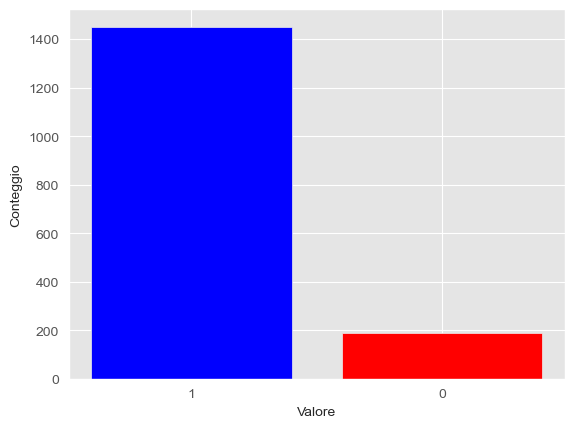

In [89]:
# Calcolare il conteggio dei valori "1" e "0" nella colonna "Positively Rated"
count_1 = df_new['Positively Rated'].value_counts()[1]
count_0 = df_new['Positively Rated'].value_counts()[0]

# Creare un grafico a barre per visualizzare il conteggio dei valori
fig, ax = plt.subplots()

# Creare le barre blu e rosse
ax.bar(['1'], [count_1], color='blue')
ax.bar(['0'], [count_0], color='red')

# Impostare le etichette degli assi
ax.set_xlabel('Valore')
ax.set_ylabel('Conteggio')

#plt.savefig('count.png')

# Mostrare il grafico
plt.show()

In [88]:
# Utilizzo della funzione .head() per visualizzare le prime 5 righe del nuovo DataFrame 'df_new'
df_new.head()

,Username,Review Number,Title,Text,Date,Rating,Id,review,Positively Rated
0,Mon-coach i,37,We had so much fun,"""We had so much fun. It was my first time goin...",2022,5,1,we had so much fun we had so much fun it was m...,1
1,GoldstarDancer,31,Shocking Overcrowding,On our trip to Rome we spent about 1/2 hrs in ...,2023,2,2,shocking overcrowding on our trip to rome we s...,0
2,theokietravelbird,47,Best Pub!,We went there for St. Patrick's Day and had a ...,2023,5,3,best pub we went there for st patricks day and...,1
3,AndreaE2327,1,Very rude security staff,"They let enter first just the girls they like,...",2023,1,4,very rude security staff they let enter first ...,0
4,R7169YHdarrenm,1,Overpriced and terrible food,For the price they charge the food is terrible...,2023,1,5,overpriced and terrible food for the price the...,0


In [133]:
from sklearn.model_selection import train_test_split

In [135]:
# Dividere il DataFrame df_new in set di addestramento e test utilizzando la funzione train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_new["review"], df_new["Positively Rated"], random_state = 50)

In [136]:
# Stampare X_train (set di addestramento)
print(X_train)

928     great atmosphere we thoroughly enjoyed our nig...
108     best irish pub best food best staff me and my ...
1229    visited this place for a few drinks on a sunda...
273     sadly lacking irish hospitality we visit irela...
696     fantastic and friendly lovely irish bar in the...
                              ...                        
75      always best irish in rome scholars is best  se...
140     rudely treated we were unkindly treated more t...
1378    return visit but very disappointed  we were so...
114     the best place thanks to mark best pub in the ...
1581    irish pub in rome this irish american found a ...
Name: review, Length: 1228, dtype: object


In [137]:
# Accedere all'elemento di indice 100 in X_train
X_train[100]

' recommend coming here amazing food the friendliest staff delicious drinks and brilliant karaoke cant wait to return to italy just for your nachos alone '

In [138]:
from sklearn.feature_extraction.text import CountVectorizer

In [139]:
# Creare un oggetto CountVectorizer e addestrarlo sul set di addestramento X_train
vect = CountVectorizer().fit(X_train)

In [141]:
# Trasformare il set di addestramento X_train utilizzando il vettorizzatore
X_train_vectorized = vect.transform(X_train)

In [142]:
from sklearn.linear_model import LogisticRegression

In [143]:
# Creare un'istanza del modello di regressione logistica
model = LogisticRegression()

# Addestrare il modello utilizzando il set di addestramento vettorizzato e i valori target y_train
model.fit(X_train_vectorized, y_train)

# Effettuare previsioni sul set di test X_test utilizzando il vettorizzatore e il modello addestrato
predictions = model.predict(vect.transform(X_test))

In [144]:
from sklearn.metrics import roc_auc_score

In [145]:
# Calcolare l'area sotto la curva ROC (AUC) utilizzando i valori target y_test e le previsioni del modello
print("AUC", roc_auc_score(y_test, predictions))

AUC 0.7615176151761519


In [146]:
# Ottenere i nomi delle features dal vettorizzatore CountVectorizer
feature_names = np.array(vect.get_feature_names_out())

In [147]:
# Ordinare gli indici dei coefficienti del modello in base all'ordine crescente
sorted_coef_index = model.coef_[0].argsort()

In [148]:
# Stampare i 10 coefficienti più piccoli e i rispettivi nomi delle features
print("Smallest Coeff", feature_names[sorted_coef_index[:10]])

Smallest Coeff ['terrible' 'poor' 'no' 'horrible' 'disappointed' 'not' 'bad' 'over'
 'awful' 'worst']


In [149]:
# Stampare i 10 coefficienti più grandi e i rispettivi nomi delle features
print("Largest Coeff", feature_names[sorted_coef_index[:-11:-1]])

Largest Coeff ['great' 'friendly' 'excellent' 'rome' 'amazing' 'fantastic' 'best' 'mark'
 'good' 'football']
